In [3]:
# Source:
    # http://blog.nextgenetics.net/?e=102
from IPython.display import HTML

HTML('''<script>
    code_show=true; 
    function code_toggle() {
     if (code_show){
     $('div.input').hide();
     } else {
     $('div.input').show();
     }
     code_show = !code_show
    } 
    $( document ).ready(code_toggle);
    </script>
    The raw code for this IPython notebook is by default hidden for easier reading.
    To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

# **INTRODUCTION**

This capstone looks at the effect of admission requirements on graduation at post-secondary institutions. 



Admission Requirements serve at least 2 purposes:

1. Limit number of applications

2. Screen for "quality" applicants

But what does "quality" mean? Generally, this would be a an applicant (student) who will be successful (i.e. graduate). 

As a Higher Education Professional working in an Admissions capacity, I looked at this relationship (admission requirements and graduation). Here was my hypothesis:

## HYPOTHESIS

**Ho:** The amount of admission requirements will have no significant correlation with graduation at the following timeframes:: 100% of normal time, 150% of normal time, or 200% of normal time.

**Ha:** There will be a positive and significant correlation between the amount of admission requirements and graduation at the following timeframes: 100% of normal time, 150% of normal time, or 200% of normal time.

## DATA

The data comes from the [Education Data](https://https://educationdata.urban.org/data-explorer/colleges/) set and there are 22050 records, and 57 variables.

My key metric was completion rates. The completion rates were defined as such:

Completion Rate is the rate of time to complete a program at a certain percentage of "normal time". "Normal Time" is defined as the recommended time to complete the program at an institution. I looked at completion rates at 100%, 150%, and 200% of normal time.

To more easily conceptualize this, imagine the following example:

At a 4-year University, 100% of "normal time" would be 4 years to complete your program. 150% would be 6 years in this example, and 200% would be 8 years in this example.

The criteria for including the data I anaylzed was 2-fold:
- Institutions must NOT have an open admissions policy
- Institutions must have data for 100, 150, and 200 percent completion rates

This reduced the size of the data I worked with to 3179 records and 20 variables.


In [36]:
# set up notebook for analysis

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
import seaborn as sns
import os


In [2]:
# load data
ed_data = pd.read_csv('/Users/gabrieldumbrille/Desktop/EducationDataPortal_12.01.2019_institutions.csv')

# get info about data
ed_data.info()
ed_data.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22050 entries, 0 to 22049
Data columns (total 57 columns):
year                       22050 non-null int64
unitid                     22050 non-null int64
inst_name                  22028 non-null object
state_name                 22050 non-null object
number_applied             7146 non-null float64
number_admitted            7139 non-null float64
number_enrolled_ft         8159 non-null float64
number_enrolled_pt         7761 non-null float64
number_enrolled_total      8171 non-null float64
reqt_hs_diploma            1393 non-null object
reqt_hs_rank               18050 non-null object
reqt_test_scores           18050 non-null object
reqt_sat_scores            1393 non-null object
reqt_other_test            12596 non-null object
reqt_residence             1393 non-null object
reqt_ability_to_benefit    1393 non-null object
reqt_age                   1393 non-null object
reqt_toefl                 18050 non-null object
reqt_other      

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (9,12,14,15,16,18,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(22050, 57)

## METHODS

When looking at Admission Requirements, I only counted variables that were "Required".

Using that criteria "Required", I engineered a feature called "Count Required". This would be the data I would correlation with completion rates. Additionally, I engineered 2 other features "Count Merit" and "Count Other" to examine the difference between correlations of merit based requirements (test scores) with more subjective requirements (recommendations). 

I then proceeded to check all data I would be analyzing for normality using histograms and the Shapiro-Wilk test.

In [3]:
# find values for each admission requirement

for column in ed_data.iloc[:,np.r_[9:19, 22:27]]:
    print(column)
    print(ed_data[column].unique())
    print()

reqt_hs_diploma
[nan 'Neither required nor recommended' 'Not applicable' 'Required'
 'Missing/not reported']

reqt_hs_rank
[nan 'Recommended' 'Neither required nor recommended' 'Required'
 'Considered' 'Not applicable' 'Missing/not reported']

reqt_test_scores
[nan 'Required' 'Recommended' 'Considered'
 'Neither required nor recommended' 'Not applicable'
 'Missing/not reported']

reqt_sat_scores
[nan 'Neither required nor recommended' 'Not applicable'
 'Missing/not reported' 'Required']

reqt_other_test
[nan 'Neither required nor recommended' 'Required' 'Considered'
 'Recommended' 'Missing/not reported' 'Not applicable']

reqt_residence
[nan 'Neither required nor recommended' 'Not applicable'
 'Missing/not reported' 'Required']

reqt_ability_to_benefit
[nan 'Neither required nor recommended' 'Not applicable' 'Required'
 'Missing/not reported']

reqt_age
[nan 'Required' 'Not applicable' 'Neither required nor recommended'
 'Missing/not reported']

reqt_toefl
[nan 'Recommended' 'Required'


I did not use the "years_college_required" requirement since there were several values for that variable that should be analyzed separately.

In [4]:
# engineer features count_required, count_required_merit, and count_required_other

col_all = ['reqt_hs_rank', 'reqt_test_scores', 'reqt_other_test', 'reqt_toefl', 'reqt_hs_gpa', 'reqt_hs_record', 'reqt_college_prep', 'reqt_recommendations', 'reqt_competencies']
col_merit = ['reqt_hs_rank', 'reqt_test_scores', 'reqt_other_test', 'reqt_toefl', 'reqt_hs_gpa', 'reqt_hs_record']
col_other = ['reqt_college_prep', 'reqt_recommendations', 'reqt_competencies']

req_all = ed_data[col_all] == 'Required'
req_merit = ed_data[col_merit] == 'Required'
req_other = ed_data[col_other] == 'Required'

ed_data['count_required'] = req_all.sum(axis=1)
ed_data['count_required_merit'] = req_merit.sum(axis=1)
ed_data['count_required_other'] = req_other.sum(axis=1)


In [5]:
# clean data

ed_data_no_open = ed_data[(ed_data['open_admissions_policy'] == 'No')]
data_grads = ed_data_no_open.dropna(subset=['completion_rate_100pct', 'completion_rate_150pct', 'completion_rate_200pct'])
data_grads_1 = data_grads.drop(data_grads.columns[4:9], axis=1)
data_grads_2 = data_grads_1.drop(data_grads_1.columns[14:17], axis=1)
data_grads_3 = data_grads_2.drop(data_grads_2.columns[19:39], axis=1)
data_no_completer = data_grads_3.drop(columns=['completion_rate_8yr', 'completion_rate_6yr', 'completers'], axis=1)
data_clean = data_no_completer.drop(columns=['completers_100pct', 'completers_150pct', 'completers_200pct','reqt_hs_diploma', 'reqt_sat_scores', 'reqt_residence', 'reqt_ability_to_benefit', 'reqt_age', 'reqt_other'], axis=1)
data_grads_clean = data_clean.dropna()
data_grads_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3179 entries, 1053 to 12547
Data columns (total 20 columns):
year                      3179 non-null int64
unitid                    3179 non-null int64
inst_name                 3179 non-null object
state_name                3179 non-null object
reqt_hs_rank              3179 non-null object
reqt_test_scores          3179 non-null object
reqt_other_test           3179 non-null object
reqt_toefl                3179 non-null object
reqt_hs_gpa               3179 non-null object
reqt_hs_record            3179 non-null object
reqt_college_prep         3179 non-null object
reqt_recommendations      3179 non-null object
reqt_competencies         3179 non-null object
institution_level         3179 non-null object
completion_rate_100pct    3179 non-null float64
completion_rate_200pct    3179 non-null float64
completion_rate_150pct    3179 non-null float64
count_required            3179 non-null int64
count_required_merit      3179 non-null int

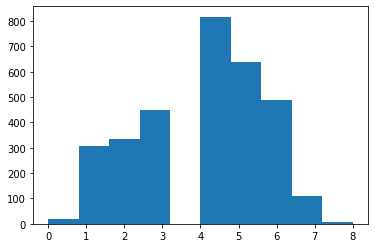

Shapiro-Wilk result = (0.9477762579917908, 3.34558887168111e-32)
DescribeResult(nobs=3179, minmax=(0, 8), mean=3.958477508650519, variance=2.7081557681377815, skewness=-0.24459171141303082, kurtosis=-0.6503609534969548)


In [37]:
# test count_required for normality

plt.hist(data_grads_clean['count_required'])
plt.show()
print('Shapiro-Wilk result =', stats.shapiro(data_grads_clean['count_required']))
print(stats.describe(data_grads_clean['count_required']))


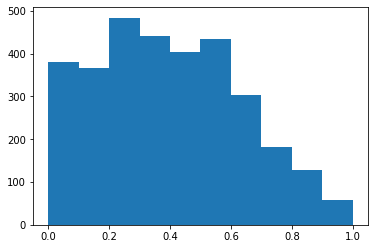

(0.9769073128700256, 2.5895344974466877e-22)
DescribeResult(nobs=3179, minmax=(0.0, 1.0), mean=0.39486945580371186, variance=0.05723864720709834, skewness=0.2810582518812222, kurtosis=-0.6881893286538032)


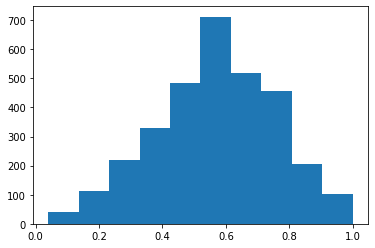

(0.994278609752655, 7.853524497392073e-10)
DescribeResult(nobs=3179, minmax=(0.04, 1.0), mean=0.5680764391318024, variance=0.03556319207844272, skewness=-0.1935418881908813, kurtosis=-0.2926650300550575)


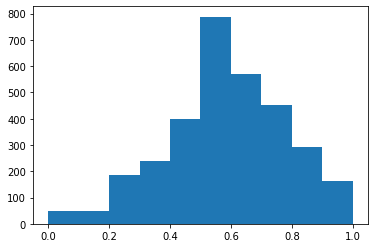

(0.9904258251190186, 8.650494735676709e-14)
DescribeResult(nobs=3179, minmax=(0.0, 1.0), mean=0.5868354828562441, variance=0.03891049872798421, skewness=-0.3023963850337264, kurtosis=0.00644146227888065)


In [7]:
# test completion_rate_100pct for normality

plt.hist(data_grads_clean['completion_rate_100pct'])
plt.show()
print(stats.shapiro(data_grads_clean['completion_rate_100pct']))
print(stats.describe(data_grads_clean['completion_rate_100pct']))

# test completion_rate_150pct for normality

plt.hist(data_grads_clean['completion_rate_150pct'])
plt.show()
print(stats.shapiro(data_grads_clean['completion_rate_150pct']))
print(stats.describe(data_grads_clean['completion_rate_150pct']))

# test completion_rate_200pct for normality

plt.hist(data_grads_clean['completion_rate_200pct'])
plt.show()
print(stats.shapiro(data_grads_clean['completion_rate_200pct']))
print(stats.describe(data_grads_clean['completion_rate_200pct']))

Based on the Shapiro-Wilk result and a visual inspection of the data, the data do not fit a normal distribution.

I then ran the correlations.

In [8]:
# correlations

print(stats.pearsonr(data_grads_clean['count_required'], data_grads_clean['completion_rate_100pct']))
print(stats.pearsonr(data_grads_clean['count_required'], data_grads_clean['completion_rate_150pct']))
print(stats.pearsonr(data_grads_clean['count_required'], data_grads_clean['completion_rate_200pct']))

(0.06994966701118996, 7.906060700871676e-05)
(0.08804489456430621, 6.629743305386797e-07)
(0.047267205326140954, 0.007687606811502838)


The correlations are almost non-existent, and all p-values are significant for "Count Required". 

To still shed light on the "amount" of requirements and its impact on graduation, I wanted to break the "Count Required" variable up into smaller groups for analysis to rule out a Simpson's paradox impacting my results.


To do this, I divided the data into 4 groups based on the quartiles of the "Count Required" column and proceeded to test the completion rates for each of the groups for normality using histograms and Shapiro_wilk.

In [9]:
# find quartiles for count_required

data_grads_clean.describe().T

,count,mean,std,min,25%,50%,75%,max
year,3179.0,2011.123938,2.877790,2007.00,2009.000,2011.000,2014.000,2016.0
unitid,3179.0,208041.565587,82442.583466,142887.00,150774.000,172440.000,238166.000,482671.0
completion_rate_100pct,3179.0,0.394869,0.239246,0.00,0.210,0.380,0.570,1.0
completion_rate_200pct,3179.0,0.586835,0.197257,0.00,0.470,0.590,0.730,1.0
completion_rate_150pct,3179.0,0.568076,0.188582,0.04,0.443,0.573,0.705,1.0
count_required,3179.0,3.958478,1.645648,0.00,3.000,4.000,5.000,8.0
count_required_merit,3179.0,3.227745,1.332074,0.00,2.000,4.000,4.000,6.0
count_required_other,3179.0,0.730733,0.717380,0.00,0.000,1.000,1.000,3.0


In [100]:
# split dataframe into groups by quartile for comparison 
# of completion rates based on quartile for count_required

data_4th = data_grads_clean[(data_grads_clean['count_required'] <= 3)]
data_3rd = data_grads_clean[(data_grads_clean['count_required'] == 4)]
data_2nd = data_grads_clean[(data_grads_clean['count_required'] == 5)]
data_1st = data_grads_clean[(data_grads_clean['count_required'] > 5)]

# view sample size of each

print(data_4th.shape)
print(data_3rd.shape)
print(data_2nd.shape)
print(data_1st.shape)

(1112, 20)
(817, 20)
(640, 20)
(610, 20)


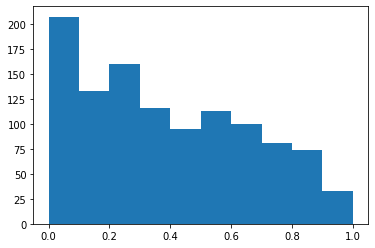

(0.9487158060073853, 3.1456536152170554e-19)
DescribeResult(nobs=1112, minmax=(0.0, 1.0), mean=0.386501798561151, variance=0.07694715751251384, skewness=0.32798583803605214, kurtosis=-1.0051071624569317)


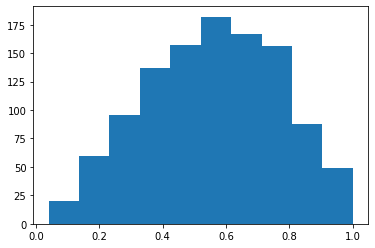

(0.9894372224807739, 3.5784756846624077e-07)
DescribeResult(nobs=1112, minmax=(0.04, 1.0), mean=0.5578902877697842, variance=0.04479881423502063, skewness=-0.11075731677225639, kurtosis=-0.6665830733600369)


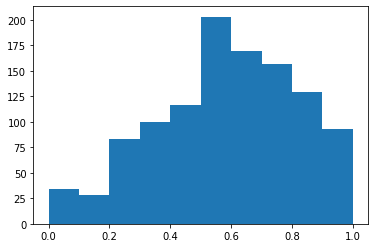

(0.980658769607544, 5.183501891603548e-11)
DescribeResult(nobs=1112, minmax=(0.0, 1.0), mean=0.5859802158273382, variance=0.05507752616088947, skewness=-0.3425341833672654, kurtosis=-0.4531839802390123)


In [11]:
# test 4th quartile for normality at each completion rate

plt.hist(data_4th['completion_rate_100pct'])
plt.show()
print(stats.shapiro(data_4th['completion_rate_100pct']))
print(stats.describe(data_4th['completion_rate_100pct']))

plt.hist(data_4th['completion_rate_150pct'])
plt.show()
print(stats.shapiro(data_4th['completion_rate_150pct']))
print(stats.describe(data_4th['completion_rate_150pct']))

plt.hist(data_4th['completion_rate_200pct'])
plt.show()
print(stats.shapiro(data_4th['completion_rate_200pct']))
print(stats.describe(data_4th['completion_rate_200pct']))

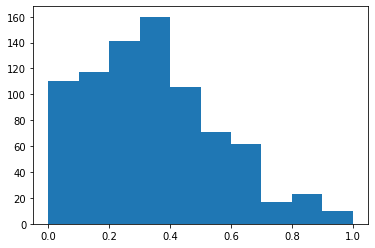

(0.9619608521461487, 9.766816397522096e-14)
DescribeResult(nobs=817, minmax=(0.0, 1.0), mean=0.3447980416156671, variance=0.04661494078047376, skewness=0.6166631866313645, kurtosis=-0.054097737142612345)


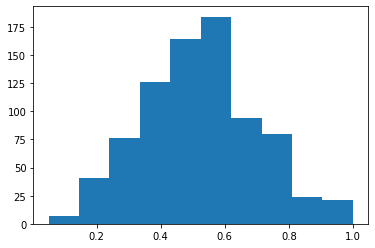

(0.9932306408882141, 0.0009267159621231258)
DescribeResult(nobs=817, minmax=(0.05, 1.0), mean=0.5212362301101592, variance=0.03194082525439797, skewness=0.19131594858780424, kurtosis=-0.19053446885452185)


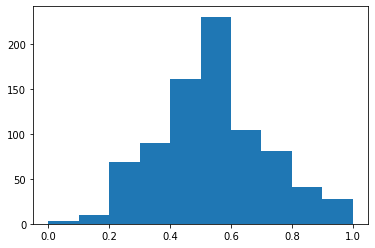

(0.9914730191230774, 0.00011678191367536783)
DescribeResult(nobs=817, minmax=(0.0, 1.0), mean=0.5362301101591187, variance=0.03222376070991432, skewness=0.20635108609980124, kurtosis=-0.062105598508030546)


In [12]:
# test 3rd quartile for normality at each completion rate

plt.hist(data_3rd['completion_rate_100pct'])
plt.show()
print(stats.shapiro(data_3rd['completion_rate_100pct']))
print(stats.describe(data_3rd['completion_rate_100pct']))

plt.hist(data_3rd['completion_rate_150pct'])
plt.show()
print(stats.shapiro(data_3rd['completion_rate_150pct']))
print(stats.describe(data_3rd['completion_rate_150pct']))

plt.hist(data_3rd['completion_rate_200pct'])
plt.show()
print(stats.shapiro(data_3rd['completion_rate_200pct']))
print(stats.describe(data_3rd['completion_rate_200pct']))

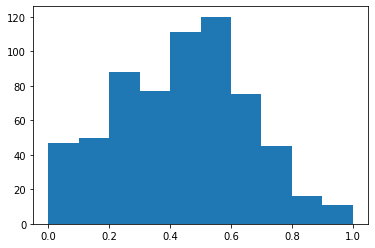

(0.9897404909133911, 0.00019085968961007893)
DescribeResult(nobs=640, minmax=(0.0, 1.0), mean=0.4379375, variance=0.04740387715179969, skewness=0.06811336675525853, kurtosis=-0.4794796764515623)


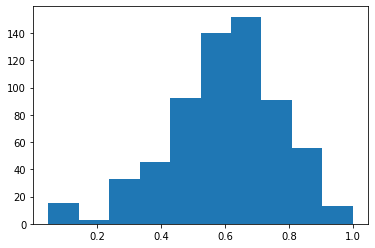

(0.9789499044418335, 5.820676918233403e-08)
DescribeResult(nobs=640, minmax=(0.048, 1.0), mean=0.5988515624999999, variance=0.030230599215082157, skewness=-0.5618090706192469, kurtosis=0.5111417721880205)


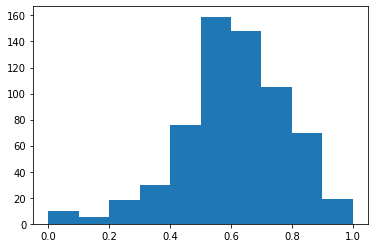

(0.9804513454437256, 1.5341508685651206e-07)
DescribeResult(nobs=640, minmax=(0.0, 1.0), mean=0.612375, variance=0.030394037558685447, skewness=-0.5078075948369302, kurtosis=0.734553413311819)


In [13]:
# test 2nd quartile for normality at each completion rate

plt.hist(data_2nd['completion_rate_100pct'])
plt.show()
print(stats.shapiro(data_2nd['completion_rate_100pct']))
print(stats.describe(data_2nd['completion_rate_100pct']))

plt.hist(data_2nd['completion_rate_150pct'])
plt.show()
print(stats.shapiro(data_2nd['completion_rate_150pct']))
print(stats.describe(data_2nd['completion_rate_150pct']))

plt.hist(data_2nd['completion_rate_200pct'])
plt.show()
print(stats.shapiro(data_2nd['completion_rate_200pct']))
print(stats.describe(data_2nd['completion_rate_200pct']))

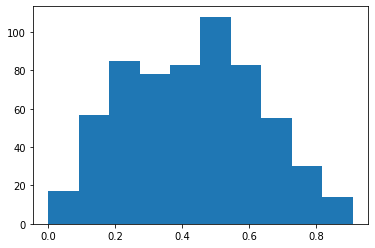

(0.98659348487854, 2.1719240976381116e-05)
DescribeResult(nobs=610, minmax=(0.0, 0.91), mean=0.432, variance=0.03929878489326766, skewness=0.05194899495903788, kurtosis=-0.7318428351027761)


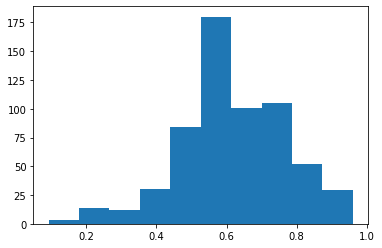

(0.9821650981903076, 8.740108796700952e-07)
DescribeResult(nobs=610, minmax=(0.09300000000000001, 0.96), mean=0.6170918032786885, variance=0.022804132773425932, skewness=-0.2915102909926676, kurtosis=0.4032799652803103)


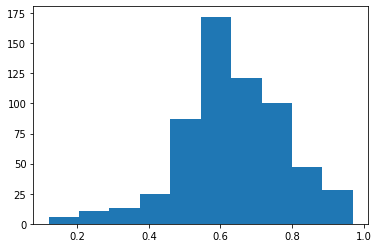

(0.9798624515533447, 1.9369232973076578e-07)
DescribeResult(nobs=610, minmax=(0.12, 0.97), mean=0.6293770491803279, variance=0.021569069423133864, skewness=-0.35319630239860156, kurtosis=0.6737193537305575)


In [72]:
# test 1st quartile for normality at each completion rate

plt.hist(data_1st['completion_rate_100pct'])
plt.show()
print(stats.shapiro(data_1st['completion_rate_100pct']))
print(stats.describe(data_1st['completion_rate_100pct']))

plt.hist(data_1st['completion_rate_150pct'])
plt.show()
print(stats.shapiro(data_1st['completion_rate_150pct']))
print(stats.describe(data_1st['completion_rate_150pct']))

plt.hist(data_1st['completion_rate_200pct'])
plt.show()
print(stats.shapiro(data_1st['completion_rate_200pct']))
print(stats.describe(data_1st['completion_rate_200pct']))



Once normality was tested, I again observed a result of non-normal distribution. 

Therefore to examine the variance among quartiles I decided to use the Kruskal-Wallis test.


In [85]:
# kruskal among quartiles for each completion rate

table_all = {'Kruskal-Wallis Completion Rate': ['100 Percent', '150 Percent', '200 Percent'],
             'H Statistic':[stats.kruskal(data_4th['completion_rate_100pct'], data_3rd['completion_rate_100pct'], data_2nd['completion_rate_100pct'], data_1st['completion_rate_100pct'])[0], 
                            stats.kruskal(data_4th['completion_rate_150pct'], data_3rd['completion_rate_150pct'], data_2nd['completion_rate_150pct'], data_1st['completion_rate_150pct'])[0], 
                            stats.kruskal(data_4th['completion_rate_200pct'], data_3rd['completion_rate_200pct'], data_2nd['completion_rate_200pct'], data_1st['completion_rate_200pct'])[0]],
             'p-value': [stats.kruskal(data_4th['completion_rate_100pct'], data_3rd['completion_rate_100pct'], data_2nd['completion_rate_100pct'], data_1st['completion_rate_100pct'])[1], 
                         stats.kruskal(data_4th['completion_rate_150pct'], data_3rd['completion_rate_150pct'], data_2nd['completion_rate_150pct'], data_1st['completion_rate_150pct'])[1], 
                         stats.kruskal(data_4th['completion_rate_200pct'], data_3rd['completion_rate_200pct'], data_2nd['completion_rate_200pct'], data_1st['completion_rate_200pct'])[1]],
            
             }
df_all = pd.DataFrame(data=table_all)
df_all
df.style.set_caption('Kruskal-Wallis at each Completion Rate')


,Kruskal_Wallis Quartile Pair,H Statistic,p-value
0,4th and 1st,19.9194,8.07755e-06
1,4th and 2nd,22.484,2.11897e-06
2,4th and 3rd,5.17539,0.022909
3,3rd and 2nd,71.0556,3.47307e-17
4,3rd and 1st,69.6325,7.14515e-17
5,2nd and 1st,0.186059,0.666217


There appears to be great variance among the groups for each completion rate. Seeing this, I decided to run Kurskal-Wallis tests for each pair of groups.

In [86]:
# kruskal for 100pct completion rate

table_100 = {'Kruskal-Wallis Quartile Pair': ['4th and 1st', '4th and 2nd', '4th and 3rd', '3rd and 2nd', '3rd and 1st', '2nd and 1st'],
             'H Statistic':[stats.kruskal(data_4th['completion_rate_100pct'], data_1st['completion_rate_100pct'])[0], 
                            stats.kruskal(data_4th['completion_rate_100pct'], data_2nd['completion_rate_100pct'])[0], 
                            stats.kruskal(data_4th['completion_rate_100pct'], data_3rd['completion_rate_100pct'])[0], 
                            stats.kruskal(data_3rd['completion_rate_100pct'], data_2nd['completion_rate_100pct'])[0], 
                            stats.kruskal(data_3rd['completion_rate_100pct'], data_1st['completion_rate_100pct'])[0], 
                            stats.kruskal(data_2nd['completion_rate_100pct'], data_1st['completion_rate_100pct'])[0]], 
             'p-value':[stats.kruskal(data_4th['completion_rate_100pct'], data_1st['completion_rate_100pct'])[1], 
                        stats.kruskal(data_4th['completion_rate_100pct'], data_2nd['completion_rate_100pct'])[1], 
                        stats.kruskal(data_4th['completion_rate_100pct'], data_3rd['completion_rate_100pct'])[1], 
                        stats.kruskal(data_3rd['completion_rate_100pct'], data_2nd['completion_rate_100pct'])[1], 
                        stats.kruskal(data_3rd['completion_rate_100pct'], data_1st['completion_rate_100pct'])[1], 
                        stats.kruskal(data_2nd['completion_rate_100pct'], data_1st['completion_rate_100pct'])[1]],
            }
df_100 = pd.DataFrame(data=table_100)
df_100
df.style.set_caption('Kruskal-Wallis at the 100 Percent Completion Rate')

,Kruskal_Wallis Quartile Pair,H Statistic,p-value
0,4th and 1st,19.9194,8.07755e-06
1,4th and 2nd,22.484,2.11897e-06
2,4th and 3rd,5.17539,0.022909
3,3rd and 2nd,71.0556,3.47307e-17
4,3rd and 1st,69.6325,7.14515e-17
5,2nd and 1st,0.186059,0.666217


In [83]:
# kruskal for 150 pct completion rate

table_150 = {'Kruskal-Wallis Quartile Pair': ['4th and 1st', '4th and 2nd', '4th and 3rd', '3rd and 2nd', '3rd and 1st', '2nd and 1st'],
             'H Statistic':[stats.kruskal(data_4th['completion_rate_150pct'], data_1st['completion_rate_150pct'])[0], 
                            stats.kruskal(data_4th['completion_rate_150pct'], data_2nd['completion_rate_150pct'])[0], 
                            stats.kruskal(data_4th['completion_rate_150pct'], data_3rd['completion_rate_150pct'])[0], 
                            stats.kruskal(data_3rd['completion_rate_150pct'], data_2nd['completion_rate_150pct'])[0], 
                            stats.kruskal(data_3rd['completion_rate_150pct'], data_1st['completion_rate_150pct'])[0], 
                            stats.kruskal(data_2nd['completion_rate_150pct'], data_1st['completion_rate_150pct'])[0]], 
             'p-value':[stats.kruskal(data_4th['completion_rate_150pct'], data_1st['completion_rate_150pct'])[1], 
                        stats.kruskal(data_4th['completion_rate_150pct'], data_2nd['completion_rate_150pct'])[1], 
                        stats.kruskal(data_4th['completion_rate_150pct'], data_3rd['completion_rate_150pct'])[1], 
                        stats.kruskal(data_3rd['completion_rate_150pct'], data_2nd['completion_rate_150pct'])[1], 
                        stats.kruskal(data_3rd['completion_rate_150pct'], data_1st['completion_rate_150pct'])[1], 
                        stats.kruskal(data_2nd['completion_rate_150pct'], data_1st['completion_rate_150pct'])[1]],
            }
df_150 = pd.DataFrame(data=table_150)
df_150
df.style.set_caption('Kruskal-Wallis at the 150 Percent Completion Rate')

,Kruskal_Wallis Quartile Pair,H Statistic,p-value
0,4th and 1st,19.9194,8.07755e-06
1,4th and 2nd,22.484,2.11897e-06
2,4th and 3rd,5.17539,0.022909
3,3rd and 2nd,71.0556,3.47307e-17
4,3rd and 1st,69.6325,7.14515e-17
5,2nd and 1st,0.186059,0.666217


In [87]:
# kruskal for 200 pct completion rate

table_200 = {'Kruskal-Wallis Quartile Pair': ['4th and 1st', '4th and 2nd', '4th and 3rd', '3rd and 2nd', '3rd and 1st', '2nd and 1st'],
             'H Statistic':[stats.kruskal(data_4th['completion_rate_200pct'], data_1st['completion_rate_200pct'])[0], 
                            stats.kruskal(data_4th['completion_rate_200pct'], data_2nd['completion_rate_200pct'])[0], 
                            stats.kruskal(data_4th['completion_rate_200pct'], data_3rd['completion_rate_200pct'])[0], 
                            stats.kruskal(data_3rd['completion_rate_200pct'], data_2nd['completion_rate_200pct'])[0], 
                            stats.kruskal(data_3rd['completion_rate_200pct'], data_1st['completion_rate_200pct'])[0], 
                            stats.kruskal(data_2nd['completion_rate_200pct'], data_1st['completion_rate_200pct'])[0]], 
             'p-value':[stats.kruskal(data_4th['completion_rate_200pct'], data_1st['completion_rate_200pct'])[1], 
                        stats.kruskal(data_4th['completion_rate_200pct'], data_2nd['completion_rate_200pct'])[1], 
                        stats.kruskal(data_4th['completion_rate_200pct'], data_3rd['completion_rate_200pct'])[1], 
                        stats.kruskal(data_3rd['completion_rate_200pct'], data_2nd['completion_rate_200pct'])[1], 
                        stats.kruskal(data_3rd['completion_rate_200pct'], data_1st['completion_rate_200pct'])[1], 
                        stats.kruskal(data_2nd['completion_rate_200pct'], data_1st['completion_rate_200pct'])[1]],
            }
df_200 = pd.DataFrame(data=table_200)
df_200
df.style.set_caption('Kruskal-Wallis at the 200 Percent Completion Rate')

,Kruskal_Wallis Quartile Pair,H Statistic,p-value
0,4th and 1st,19.9194,8.07755e-06
1,4th and 2nd,22.484,2.11897e-06
2,4th and 3rd,5.17539,0.022909
3,3rd and 2nd,71.0556,3.47307e-17
4,3rd and 1st,69.6325,7.14515e-17
5,2nd and 1st,0.186059,0.666217


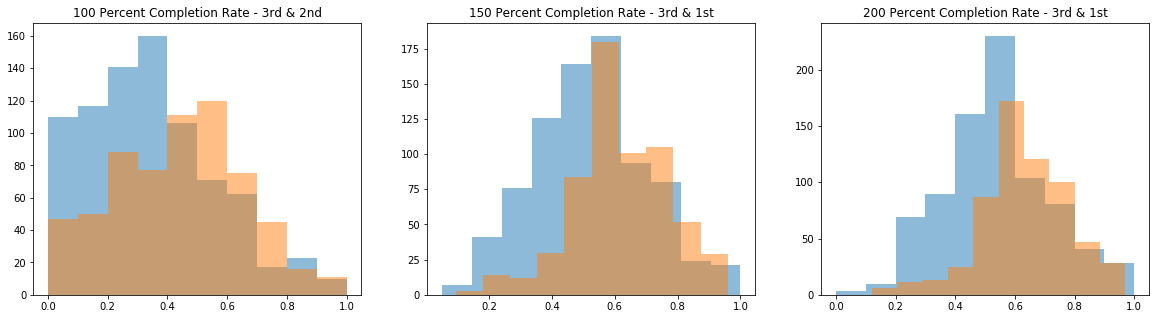

In [99]:
# visualizing difference among quartiles for each completion rate
# use largest difference value pair

plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
plt.hist(data_3rd['completion_rate_100pct'], alpha=0.5)
plt.hist(data_2nd['completion_rate_100pct'], alpha=0.5)
plt.title('100 Percent Completion Rate - 3rd & 2nd')

plt.subplot(1,3,2)
plt.hist(data_3rd['completion_rate_150pct'], alpha=0.5)
plt.hist(data_1st['completion_rate_150pct'], alpha=0.5)
plt.title('150 Percent Completion Rate - 3rd & 1st')

plt.subplot(1,3,3)
plt.hist(data_3rd['completion_rate_200pct'], alpha=0.5)
plt.hist(data_1st['completion_rate_200pct'], alpha=0.5)
plt.title('200 Percent Completion Rate - 3rd & 1st')

plt.show()

There seem to exist substantial and significant variance among the groups. Specifically, there seemed to be the biggest difference between group 3 and groups 1 or 2.


The 3rd group represents institutions with 4 admission requirements. The 2nd and 1st groups represent institutions with 5 or more quartiles (5 for the 2nd quartile, and more than 5 for the 1st quartile). 

I began to wonder with such variance existing bewteen 4 admission requirements and 5 or more admission requirements if there could still be a correlation with completion rate for admission requirements; specifically at 5 or more requirements.

These results suggest to me that there may be a "tipping point" where the amount of requirements starts to correlate more with completion rate at 5 or more admission requirements.

To examine this "tipping point" I did correlations at each increment above the minimum and below the maximum for each completion rate.

In [20]:
# demonstrating "tipping point" for count_required correlation with completion rate at each rate

def format_print(series_1, series_2, completion_rate):
    print(completion_rate)
    for num in reversed(range(1, 8)):
        print(num, 'or more requirements:', 'r =', round(stats.pearsonr(series_1 >= num, series_2)[0], 5), ', p-value =', round(stats.pearsonr(series_1 >= num, series_2)[1], 5))
    print()
       
format_print(data_grads_clean['count_required'],  data_grads_clean['completion_rate_100pct'], '100% Completion Rate')
format_print(data_grads_clean['count_required'],  data_grads_clean['completion_rate_150pct'], '150% Completion Rate')
format_print(data_grads_clean['count_required'],  data_grads_clean['completion_rate_200pct'], '200% Completion Rate')

100% Completion Rate
7 or more requirements: r = 0.07925 , p-value = 1e-05
6 or more requirements: r = 0.07564 , p-value = 2e-05
5 or more requirements: r = 0.13518 , p-value = 0.0
4 or more requirements: r = 0.02566 , p-value = 0.1481
3 or more requirements: r = 0.01388 , p-value = 0.434
2 or more requirements: r = -0.04341 , p-value = 0.01438
1 or more requirements: r = 0.0009 , p-value = 0.95972

150% Completion Rate
7 or more requirements: r = 0.07559 , p-value = 2e-05
6 or more requirements: r = 0.12667 , p-value = 0.0
5 or more requirements: r = 0.16939 , p-value = 0.0
4 or more requirements: r = 0.03962 , p-value = 0.02548
3 or more requirements: r = 0.02611 , p-value = 0.14105
2 or more requirements: r = -0.10675 , p-value = 0.0
1 or more requirements: r = 0.00648 , p-value = 0.71488

200% Completion Rate
7 or more requirements: r = 0.06352 , p-value = 0.00034
6 or more requirements: r = 0.10511 , p-value = 0.0
5 or more requirements: r = 0.13811 , p-value = 0.0
4 or more requi

At each completion rate the highest r-value was for the 5 or more threshold, and that number went down for each increment above 5 or more (i.e 6 or more and 7 or more). 

This is interesting since the greatest differences in the Kruskal-Wallis test were observed when going from the 3rd quartile (4 total requirements) to the 2nd or 1st quartile (5 or more requirements).





A secondary component of my research proposal was to look at 2 groupings of admission requirements: merit based (test scores, etc...) and other (recommendations, competencies, etc...). 

This grouping was designed to see if there is a difference in completion rate correlation based on the type of admission requirement.

I looked at correlations and scatterplots for both "Count Required Merit" and "Count Required Other" for each completion rate.

In [101]:
# correlations between count_required_merit and count_required_other at each completion rate

def format_print_merit_other(series_1, series_2, series_3, series_4, count_type):
    print(count_type)
    print('100pct Completion Rate:', 'r =', round(stats.pearsonr(series_1, series_2)[0], 5), ', p-value =', round(stats.pearsonr(series_1, series_2)[1], 5))
    print('150pct Completion Rate:', 'r =', round(stats.pearsonr(series_1, series_3)[0], 5), ', p-value =', round(stats.pearsonr(series_1, series_3)[1], 5))
    print('200pct Completion Rate:', 'r =', round(stats.pearsonr(series_1, series_4)[0], 5), ', p-value =', round(stats.pearsonr(series_1, series_4)[1], 5))
    print()

format_print_merit_other(data_grads_clean['count_required_merit'], data_grads_clean['completion_rate_100pct'], data_grads_clean['completion_rate_150pct'], data_grads_clean['completion_rate_200pct'], 'Correlation with "Count Required Merit"')
format_print_merit_other(data_grads_clean['count_required_other'], data_grads_clean['completion_rate_100pct'], data_grads_clean['completion_rate_150pct'], data_grads_clean['completion_rate_200pct'], 'Correlation with "Count Required Other"')

Correlation with "Count Required Merit"
100pct Completion Rate: r = -0.05795 , p-value = 0.00108
150pct Completion Rate: r = -0.04565 , p-value = 0.01005
200pct Completion Rate: r = -0.07644 , p-value = 2e-05

Correlation with "Count Required Other"
100pct Completion Rate: r = 0.26807 , p-value = 0.0
150pct Completion Rate: r = 0.28674 , p-value = 0.0
200pct Completion Rate: r = 0.25036 , p-value = 0.0



Remarkably there is a stark difference between the correlations for "Count Required Merit" and "Count Required Other" at each completion rate. 

The following visualizations further illustrate this difference. The data being plotted is "Count Required" for each completion rate, with the hue of the plot as "Count Required Merit" or "Count Required Other" to show the composition of "Count Required".


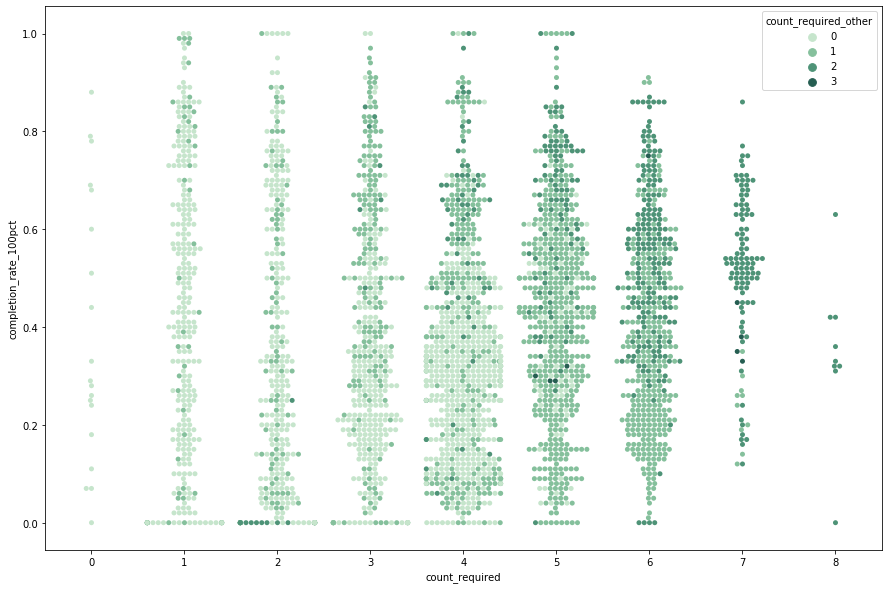

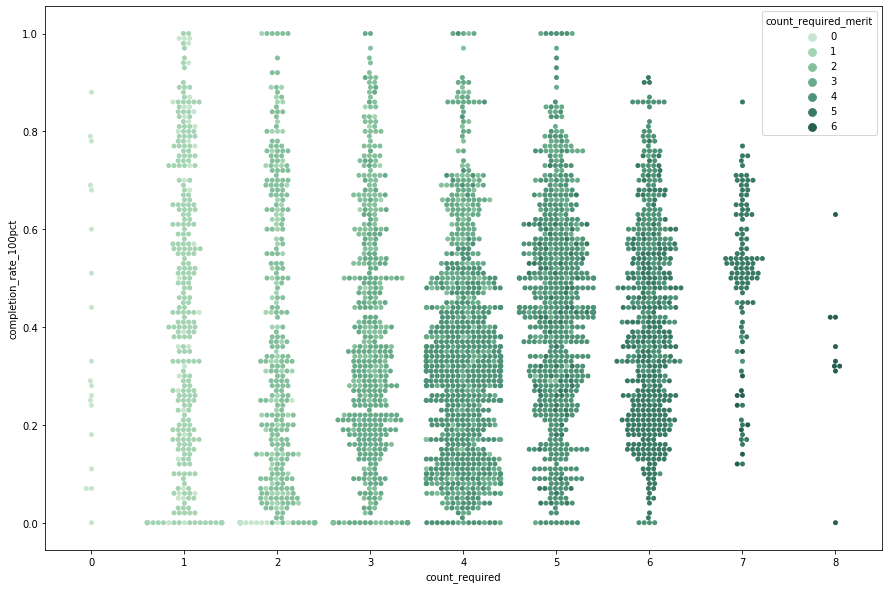

In [22]:
# visualize merit vs. other for 100pct completion

plt.figure(figsize=(15,10))
sns.swarmplot(x='count_required', y='completion_rate_100pct', hue='count_required_other', palette="ch:2.5,-.2,dark=.3", data=data_grads_clean)
plt.show()

plt.figure(figsize=(15,10))
sns.swarmplot(x='count_required', y='completion_rate_100pct', hue='count_required_merit', palette="ch:2.5,-.2,dark=.3", data=data_grads_clean)
plt.show()

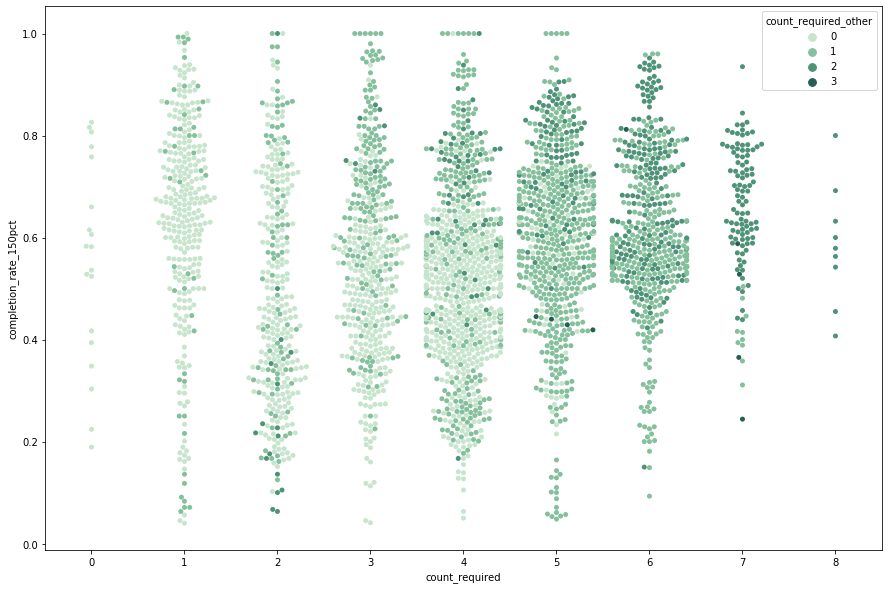

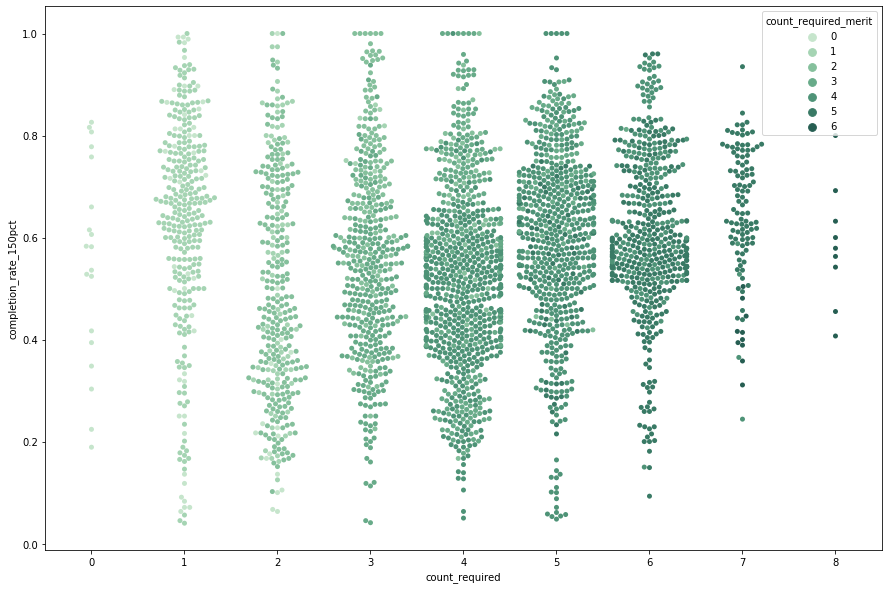

In [23]:
# visualize merit vs. other for 150pct completion

plt.figure(figsize=(15,10))
sns.swarmplot(x='count_required', y='completion_rate_150pct', hue='count_required_other', palette="ch:2.5,-.2,dark=.3", data=data_grads_clean)
plt.show()

plt.figure(figsize=(15,10))
sns.swarmplot(x='count_required', y='completion_rate_150pct', hue='count_required_merit', palette="ch:2.5,-.2,dark=.3", data=data_grads_clean)
plt.show()

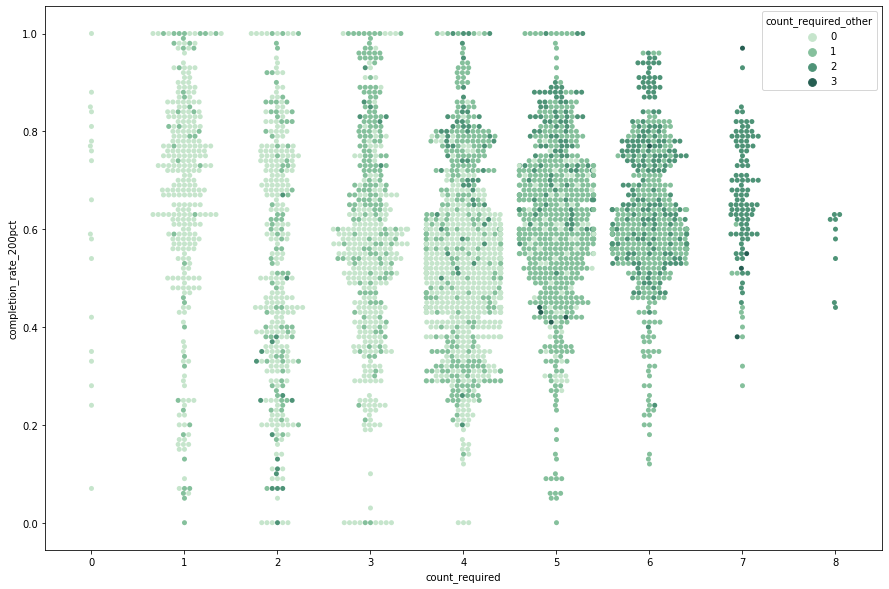

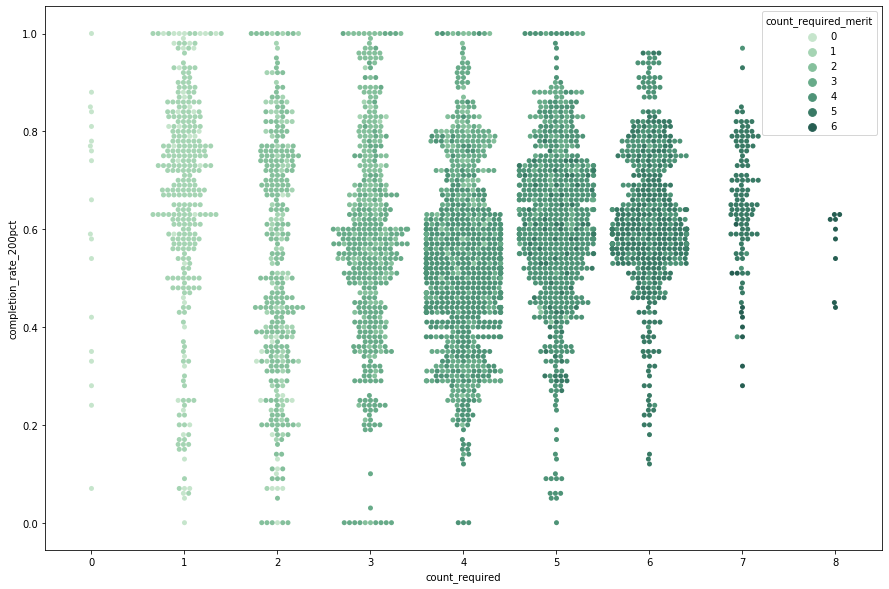

In [24]:
# visualize merit vs. other for 200pct completion

plt.figure(figsize=(15,10))
sns.swarmplot(x='count_required', y='completion_rate_200pct', hue='count_required_other', palette="ch:2.5,-.2,dark=.3", data=data_grads_clean)
plt.show()

plt.figure(figsize=(15,10))
sns.swarmplot(x='count_required', y='completion_rate_200pct', hue='count_required_merit', palette="ch:2.5,-.2,dark=.3", data=data_grads_clean)
plt.show()



Another part of my study was to look at differences in "Count Required" and completion rate correlations among states. My data contained records from 5 states. 

I checked the correlations for "Count Required", "Count Required Merit", and "Count Required Other".


In [25]:
# prepare data for state comparison of count_required vs. completion rates

data_grads_mi = data_grads_clean[(data_grads_clean['state_name'] == 'Michigan')]
data_grads_wi = data_grads_clean[(data_grads_clean['state_name'] == 'Wisconsin')]
data_grads_in = data_grads_clean[(data_grads_clean['state_name'] == 'Indiana')]
data_grads_oh = data_grads_clean[(data_grads_clean['state_name'] == 'Ohio')]
data_grads_il = data_grads_clean[(data_grads_clean['state_name'] == 'Illinois')]

In [26]:
# test correlation with completion rates in Michigan

data_grads_mi.corr()

,year,unitid,completion_rate_100pct,completion_rate_200pct,completion_rate_150pct,count_required,count_required_merit,count_required_other
year,1.000000,-0.259227,-0.108094,-0.079771,-0.082364,0.257228,0.252542,0.124794
unitid,-0.259227,1.000000,0.105118,-0.030596,0.044003,-0.495438,-0.521630,-0.179913
completion_rate_100pct,-0.108094,0.105118,1.000000,0.720136,0.718688,-0.043527,-0.211752,0.268986
completion_rate_200pct,-0.079771,-0.030596,0.720136,1.000000,0.783724,0.002177,-0.136540,0.239082
completion_rate_150pct,-0.082364,0.044003,0.718688,0.783724,1.000000,0.030626,-0.115572,0.264836
count_required,0.257228,-0.495438,-0.043527,0.002177,0.030626,1.000000,0.893427,0.636805
count_required_merit,0.252542,-0.521630,-0.211752,-0.136540,-0.115572,0.893427,1.000000,0.222588
count_required_other,0.124794,-0.179913,0.268986,0.239082,0.264836,0.636805,0.222588,1.000000


In [27]:
# test correlation with completion rates in Wisconsin

data_grads_wi.corr()

,year,unitid,completion_rate_100pct,completion_rate_200pct,completion_rate_150pct,count_required,count_required_merit,count_required_other
year,1.000000,-0.018972,-0.041923,-0.110988,-0.065169,0.049397,0.060360,-0.001953
unitid,-0.018972,1.000000,0.064193,0.013923,0.060093,-0.363487,-0.389740,-0.108759
completion_rate_100pct,-0.041923,0.064193,1.000000,0.779586,0.677244,-0.136916,-0.221050,0.127035
completion_rate_200pct,-0.110988,0.013923,0.779586,1.000000,0.843196,-0.014494,-0.121418,0.235244
completion_rate_150pct,-0.065169,0.060093,0.677244,0.843196,1.000000,0.014169,-0.105321,0.276939
count_required,0.049397,-0.363487,-0.136916,-0.014494,0.014169,1.000000,0.936279,0.606834
count_required_merit,0.060360,-0.389740,-0.221050,-0.121418,-0.105321,0.936279,1.000000,0.288977
count_required_other,-0.001953,-0.108759,0.127035,0.235244,0.276939,0.606834,0.288977,1.000000


In [28]:
# test correlation with completion rates in Indiana

data_grads_in.corr()

,year,unitid,completion_rate_100pct,completion_rate_200pct,completion_rate_150pct,count_required,count_required_merit,count_required_other
year,1.000000,-0.148297,0.012192,-0.044246,0.009713,0.064765,0.102973,-0.029964
unitid,-0.148297,1.000000,0.040680,0.075529,-0.000323,-0.431429,-0.452833,-0.204306
completion_rate_100pct,0.012192,0.040680,1.000000,0.878156,0.828686,0.203699,0.124035,0.252005
completion_rate_200pct,-0.044246,0.075529,0.878156,1.000000,0.885696,0.172997,0.064612,0.284591
completion_rate_150pct,0.009713,-0.000323,0.828686,0.885696,1.000000,0.232385,0.137132,0.295067
count_required,0.064765,-0.431429,0.203699,0.172997,0.232385,1.000000,0.913520,0.709360
count_required_merit,0.102973,-0.452833,0.124035,0.064612,0.137132,0.913520,1.000000,0.361287
count_required_other,-0.029964,-0.204306,0.252005,0.284591,0.295067,0.709360,0.361287,1.000000


In [29]:
# test correlation with completion rates in Illinois

data_grads_il.corr()

,year,unitid,completion_rate_100pct,completion_rate_200pct,completion_rate_150pct,count_required,count_required_merit,count_required_other
year,1.000000,-0.163611,0.014617,-0.073198,-0.058406,0.161639,0.149289,0.085598
unitid,-0.163611,1.000000,0.050158,0.097867,0.059048,-0.517430,-0.507102,-0.216617
completion_rate_100pct,0.014617,0.050158,1.000000,0.743052,0.712226,0.099302,0.010644,0.211904
completion_rate_200pct,-0.073198,0.097867,0.743052,1.000000,0.806995,0.022506,-0.050778,0.152553
completion_rate_150pct,-0.058406,0.059048,0.712226,0.806995,1.000000,0.069144,-0.036674,0.234184
count_required,0.161639,-0.517430,0.099302,0.022506,0.069144,1.000000,0.907103,0.561976
count_required_merit,0.149289,-0.507102,0.010644,-0.050778,-0.036674,0.907103,1.000000,0.161612
count_required_other,0.085598,-0.216617,0.211904,0.152553,0.234184,0.561976,0.161612,1.000000


In [30]:
# test correlation with completion rates in Ohio

data_grads_oh.corr()

,year,unitid,completion_rate_100pct,completion_rate_200pct,completion_rate_150pct,count_required,count_required_merit,count_required_other
year,1.000000,-0.151994,0.037591,-0.082875,-0.040278,0.151437,0.146020,0.081884
unitid,-0.151994,1.000000,0.001052,0.074234,0.038702,-0.424384,-0.427831,-0.196416
completion_rate_100pct,0.037591,0.001052,1.000000,0.725162,0.644739,0.114354,-0.022978,0.298276
completion_rate_200pct,-0.082875,0.074234,0.725162,1.000000,0.738247,0.049868,-0.105484,0.299478
completion_rate_150pct,-0.040278,0.038702,0.644739,0.738247,1.000000,0.082789,-0.075730,0.320810
count_required,0.151437,-0.424384,0.114354,0.049868,0.082789,1.000000,0.903371,0.648713
count_required_merit,0.146020,-0.427831,-0.022978,-0.105484,-0.075730,0.903371,1.000000,0.259652
count_required_other,0.081884,-0.196416,0.298276,0.299478,0.320810,0.648713,0.259652,1.000000


The same results for correlations with "Count Required Other" vs. "Count Required" and "Count Required Merit" existed among states with "Count Required Other" having the highest correlations with completion at each rate.

Indiana appeared to have a weak positive correlation with "Count Required" at each completion rate, yet the correlation with "Count Required Other" was higher than that of count_required in Indiana for each completion rate.





Below are visualizations by state of the difference between count_required_merit and count_required_other using seaborn scatterplots. 

The data being plotted is count_required by completion rate, with the hue as count_required_merit or count_required_other to show the composition of count_required.

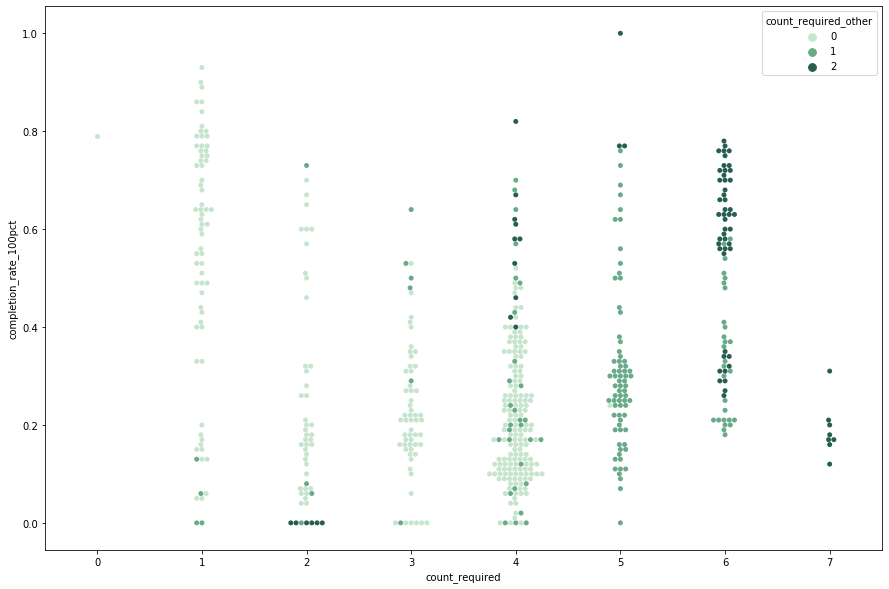

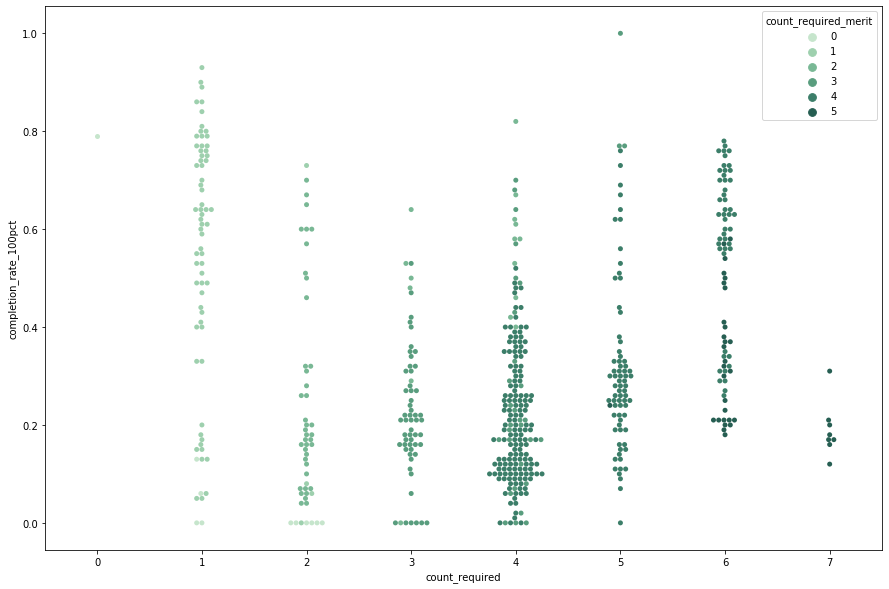

In [31]:
# visualize merit vs. other for Michigan for 100pct rate

plt.figure(figsize=(15,10))
sns.swarmplot(x='count_required', y='completion_rate_100pct', hue='count_required_other', palette="ch:2.5,-.2,dark=.3", data=data_grads_mi)
plt.show()

plt.figure(figsize=(15,10))
sns.swarmplot(x='count_required', y='completion_rate_100pct', hue='count_required_merit', palette="ch:2.5,-.2,dark=.3", data=data_grads_mi)
plt.show()


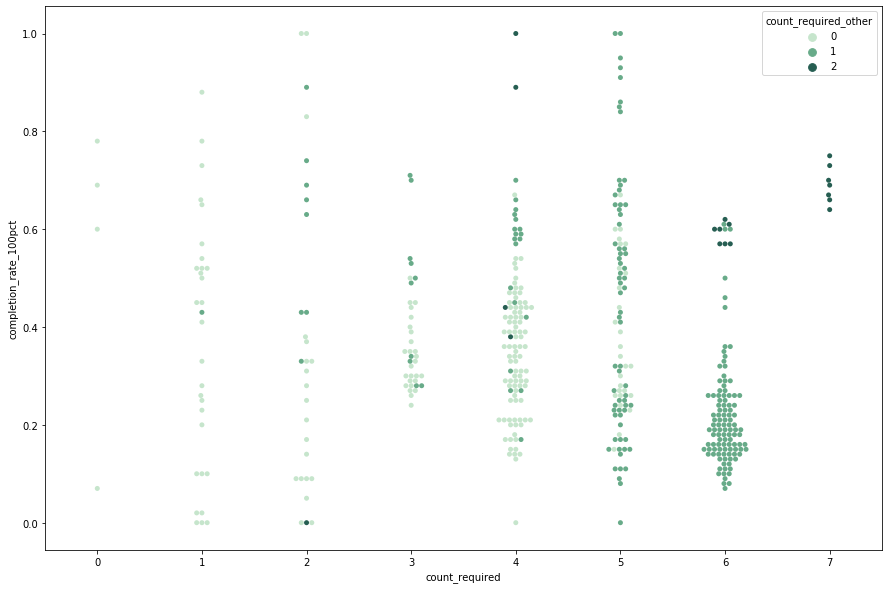

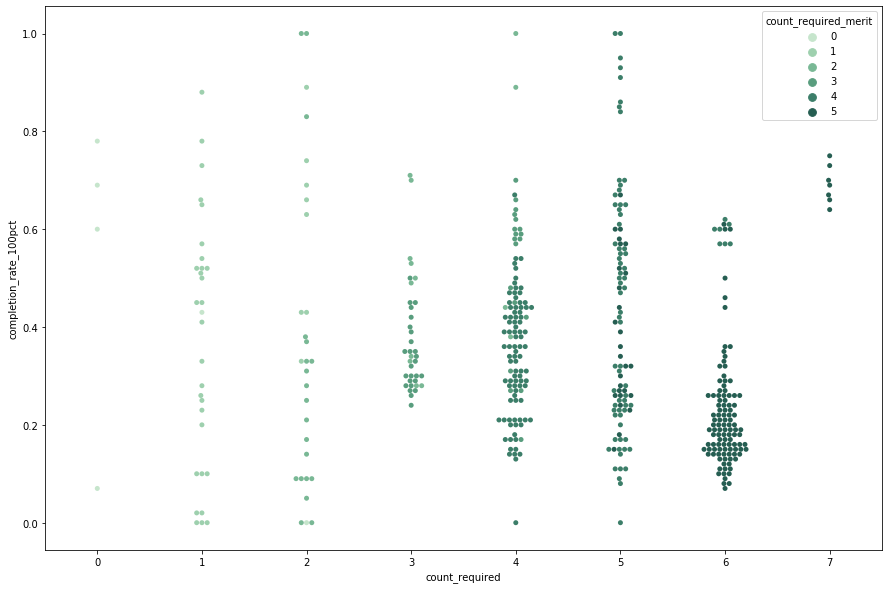

In [32]:
# visualize merit vs. other for Wisconsin for 100pct rate

plt.figure(figsize=(15,10))
sns.swarmplot(x='count_required', y='completion_rate_100pct', hue='count_required_other', palette="ch:2.5,-.2,dark=.3", data=data_grads_wi)
plt.show()

plt.figure(figsize=(15,10))
sns.swarmplot(x='count_required', y='completion_rate_100pct', hue='count_required_merit', palette="ch:2.5,-.2,dark=.3", data=data_grads_wi)
plt.show()

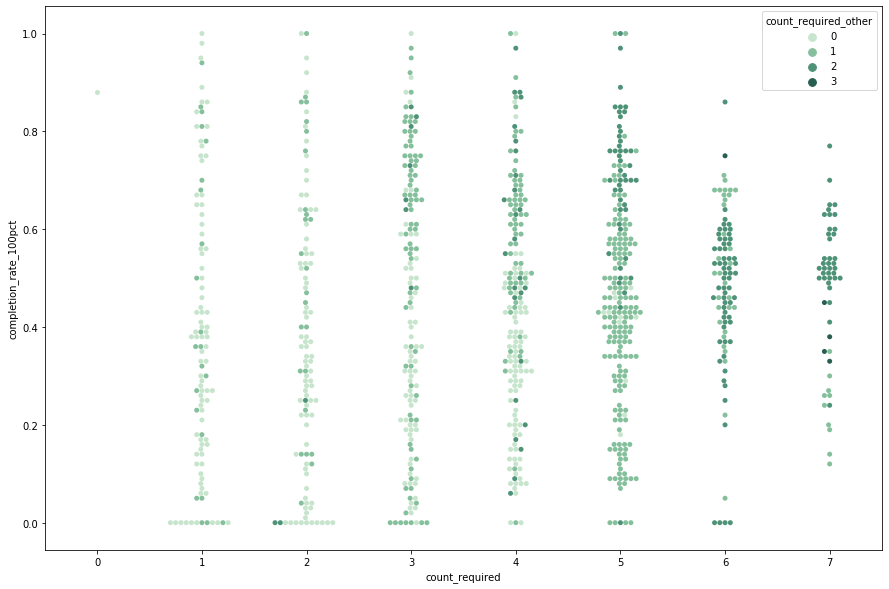

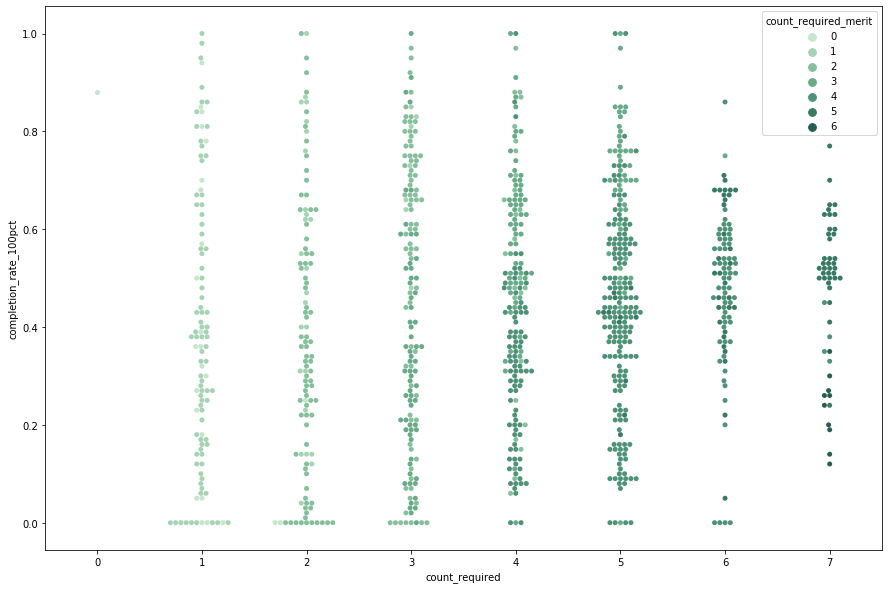

In [33]:
# visualize merit vs. other for Ohio for 100pct rate

plt.figure(figsize=(15,10))
sns.swarmplot(x='count_required', y='completion_rate_100pct', hue='count_required_other', palette="ch:2.5,-.2,dark=.3", data=data_grads_oh)
plt.show()

plt.figure(figsize=(15,10))
sns.swarmplot(x='count_required', y='completion_rate_100pct', hue='count_required_merit', palette="ch:2.5,-.2,dark=.3", data=data_grads_oh)
plt.show()

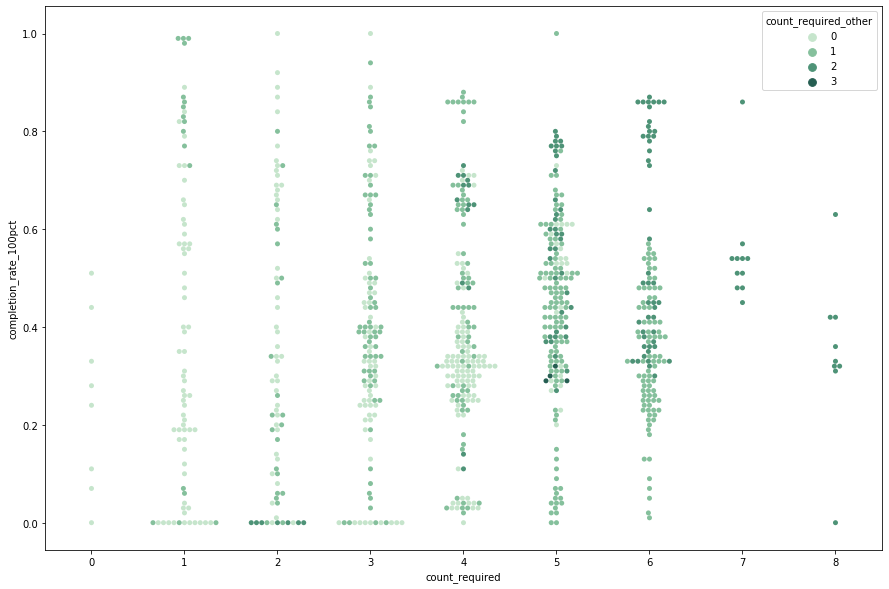

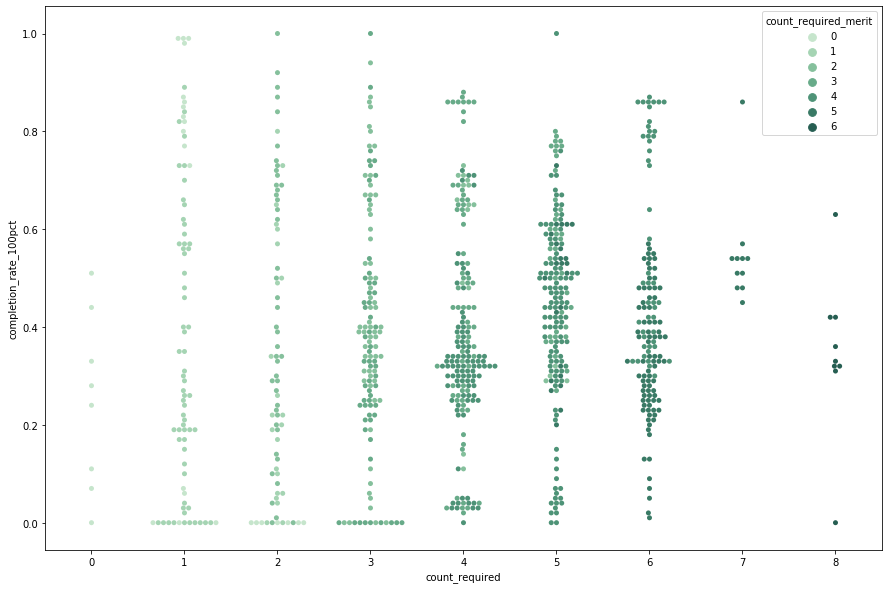

In [34]:
# visualize merit vs. other for Illinois for 100pct rate

plt.figure(figsize=(15,10))
sns.swarmplot(x='count_required', y='completion_rate_100pct', hue='count_required_other', palette="ch:2.5,-.2,dark=.3", data=data_grads_il)
plt.show()

plt.figure(figsize=(15,10))
sns.swarmplot(x='count_required', y='completion_rate_100pct', hue='count_required_merit', palette="ch:2.5,-.2,dark=.3", data=data_grads_il)
plt.show()

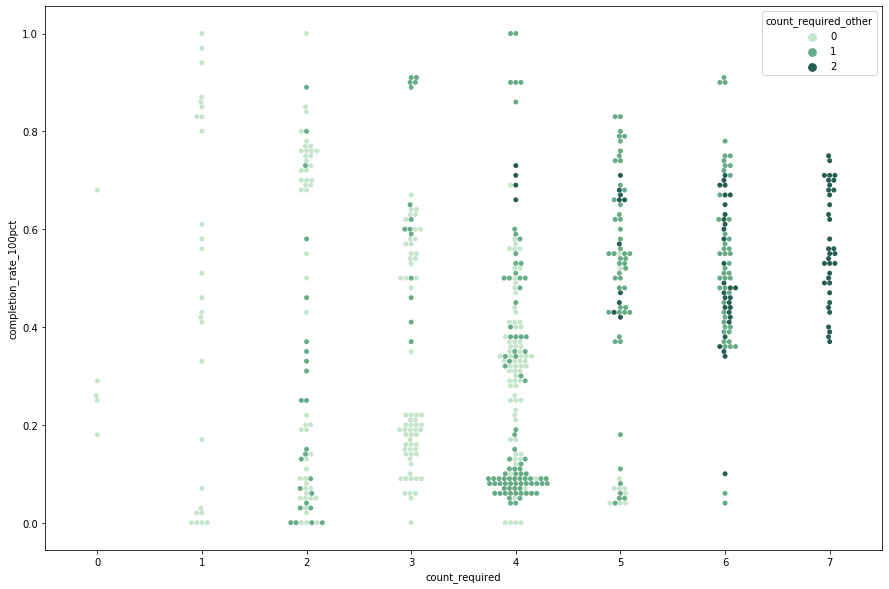

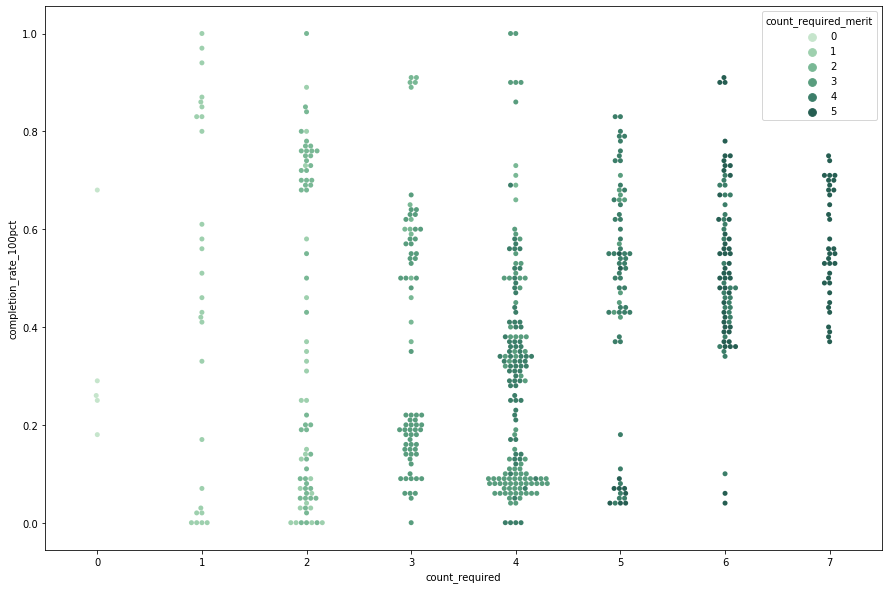

In [35]:
# visualize merit vs. other for Indiana for 100pct rate

plt.figure(figsize=(15,10))
sns.swarmplot(x='count_required', y='completion_rate_100pct', hue='count_required_other', palette="ch:2.5,-.2,dark=.3", data=data_grads_in)
plt.show()

plt.figure(figsize=(15,10))
sns.swarmplot(x='count_required', y='completion_rate_100pct', hue='count_required_merit', palette="ch:2.5,-.2,dark=.3", data=data_grads_in)
plt.show()

## CONCLUSIONS

Ultimately, this experiment does not indicate admission requirements as strong or reliable indicators of a student's ability to graduate, so I fail to reject the null hypothesis given my results.

However, it does raise questions around non-merit based admission requirements and a reason to do further research on those and their impact. 

Additionally, the results presented could indicate a "tipping point" for admission requirements at 5, or, 5 or more requirements as having a very small positive predictive correlation. 

For administrators at an institution in an admissions office, this experiment could direct them to answer the questions I have raised in the hopes of increasing the efficacy of their admission requirements, in not only reducing the number of applications, but also in selecting students who will be successful.

## LIMITATIONS

There are a few limitations to this experiment. 

First, admission requirements may have changed from the time they were instituted to the time a student graduated (or completed). Therefore, the results may not be representative of the greater population and are not "moment in time". A graduate may not have been impacted by an admission requirement that was instituted after the student was admitted, but before they graduated. However, this experiment does not consider those instances, and to do so would require studying institutions by year, and by type to narrow down the impact of admission requirements on graduates at the timeframes of 100, 150, and 200 percent of normal time.

Second, the amount of admission requirements when split into 2 groups resulted in 2 very small sample sizes. The count_required_other was only 4 values (0-3) and the count_required_merit was only 7 values (0-6). These and the resulting quartiles used for count_required could be inappropriately small samples to be using for correlations.

Third, the years_college_required variable was not used in this experiment and could have impacted the results.